In [1]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct

sample_rate, signal = scipy.io.wavfile.read('./data/0_jackson_0.wav') # sample_rate: number of samples per second
                                                                      # signal: 1D vector of audio data

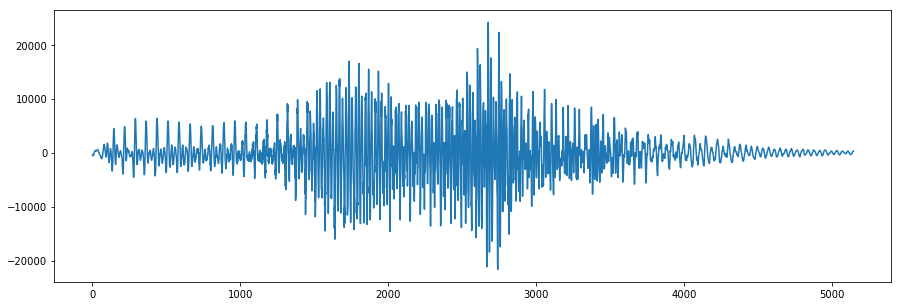

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(range(len(signal)), signal)

In [3]:
# pre-emphasized signal data
pre_emphasis = 0.97  # pre-emphasis filter coefficient
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

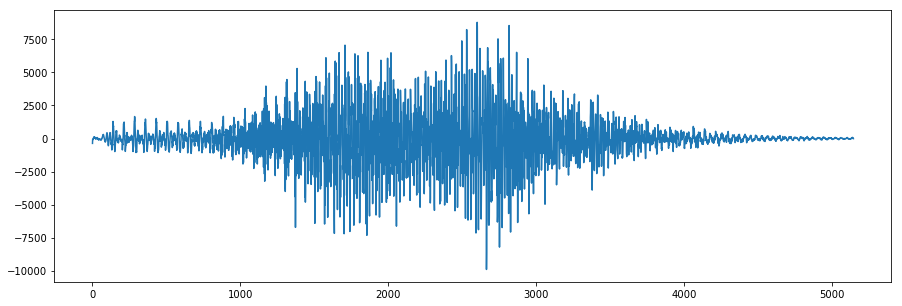

In [4]:
plt.plot(range(len(emphasized_signal)), emphasized_signal)

In [40]:
# create shorter-term frame for signal
frame_size = 0.025   # number of seconds of each frame
frame_stride = 0.01  # size of stride between two frames (frame_size - frame_stride = overlap between frames)
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
if (signal_length > frame_length):
    num_steps = int(numpy.ceil(float(signal_length - frame_length) / frame_step))
else:
    num_steps = 1
num_frames = num_steps + 1
pad_signal_length = num_steps * frame_step + frame_length # number of zeros to pad at the end of signal
pad_vector = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, pad_vector)
indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + \
            numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
          # indices in emphasized_signal to slice to form frames
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

In [41]:
# apply hamming function for FFT
frames *= numpy.hamming(frame_length)

In [42]:
signal_length, frame_length, frame_step

(5148, 200, 80)

(63, 200)

In [33]:
# Fourier Transform and Power Spectrum
NFFT = 512
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

(63, 257)

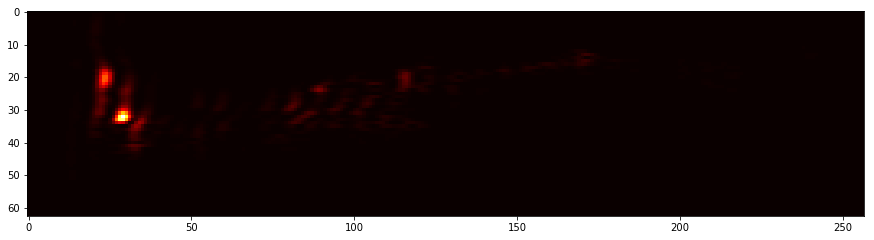

In [34]:
plt.imshow(pow_frames, cmap='hot')

In [35]:
# apply triangular filter
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale (incl. low&high freq)
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

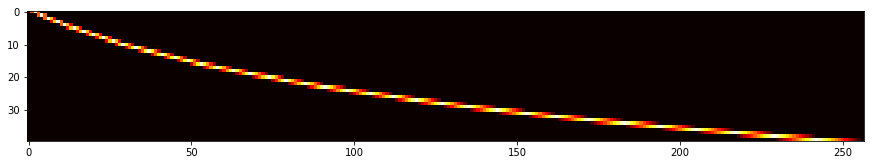

In [71]:
plt.imshow(fbank, cmap='hot', interpolation='nearest')

In [54]:
# heatmap
def heatmap(data, row_labels=None, col_labels=None, ax=None,\
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(numpy.arange(data.shape[1]))
    ax.set_yticks(numpy.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    #ax.set_xticklabels(col_labels)
    #ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
    #         rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(numpy.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(numpy.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar